In [3]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# **ACB**

In [4]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 7:3
df = pd.read_csv('DATASET/ACB Historical Data.csv')


In [5]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [6]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [7]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15322.834, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15326.634, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15326.544, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15326.853, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15326.939, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15320.859, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15321.008, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15321.327, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15322.745, Time=0.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15321.066, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15320.657, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15320.526, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15320.293, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15322.069, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True)

In [8]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [9]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[27517.20038199 27606.29116208 27608.20305696 27615.91293222
 27616.41991924 27622.07043762 27629.90701477 27640.67828677
 27653.2178318  27667.1090165  27681.83981575 27697.12726298
 27712.75754401 27728.60272587 27744.57857735 27760.63414136
 27776.73764971 27792.86996786 27809.01947177 27825.17920818
 27841.34501181 27857.51440639 27873.68592089 27889.85868502
 27906.03218455 27922.20611635 27938.38030196 27954.55463645
 27970.72905822 27986.90353112]


In [10]:
# 6. Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  33.984755456888074
RMSE:  8389.864099274993
MDA:  46.902654867256636


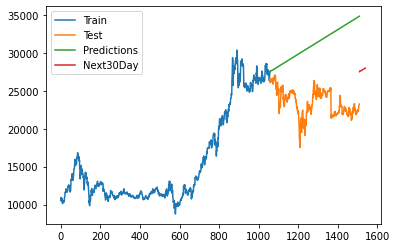

In [11]:
# 7.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# **PVS**

In [12]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 7:3
df = pd.read_csv('DATASET/PVS Historical Data.csv')

In [13]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [14]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [15]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16658.288, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16660.274, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16660.276, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16657.144, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16662.263, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.737 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


In [17]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092.
 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092.
 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092. 36092.]


In [18]:
# Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  32.530163409653696
RMSE:  9432.25733688193
MDA:  7.505518763796909


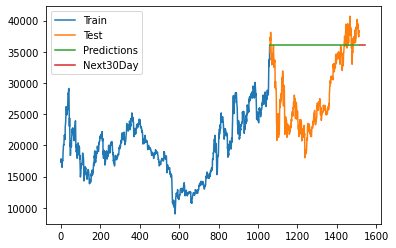

In [19]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()


# **VNM**

In [20]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 7:3
df = pd.read_csv('DATASET/VNM Historical Data.csv')

In [21]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [22]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [23]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19031.844, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19048.422, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19043.835, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19043.714, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19048.179, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19042.003, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19041.454, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19033.557, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19034.104, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19044.967, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19040.118, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19037.705, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19027.465, Time=0.92 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=19033.144, Time=1.10 sec
 ARIMA(3,1,4)(0,0,0

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [25]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[74516.92401228 74433.44079173 74510.17101444 74452.98624
 74526.48211783 74466.42136623 74522.7510097  74461.63401265
 74512.80806221 74460.89640302 74511.65840408 74466.37598392
 74512.23196497 74469.27252282 74509.52074739 74469.77994039
 74506.79295636 74471.29339354 74505.58261393 74473.37496436
 74504.43340294 74474.78703301 74502.89963897 74475.85845914
 74501.57496302 74477.04636452 74500.54685646 74478.18796566
 74499.56130358 74479.14016838]


In [26]:
# Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  5.193066295737187
RMSE:  4539.968028820638
MDA:  47.24061810154526


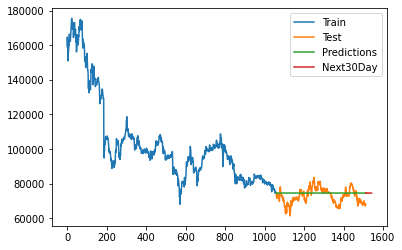

In [27]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()